In [1]:
import os
import re
import sys
import glob
import time
import uproot
import peakutils

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/') ## Choose right path
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [4]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [5]:
fav_col = '#418094'

In [6]:
## filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file_78.root'
## infile   = uproot.open(filename)
## RawTree  = infile['RawTree']

## Analyze files

In [7]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'

thr_ADC        = 80
sg_filt_window = 30
min_dist       = 50

def extract_date_obj_and_number(filename):
    match       = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    date_str    = match.group(1)
    file_number = int(match.group(2))
    date_obj    = datetime.strptime(date_str, "%m_%d_%Y")
    return date_obj, file_number

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

filt_files   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_run-*')
sorted_files = sorted(filt_files, key=extract_date_obj_and_number)

In [8]:
len(sorted_files)

1380

In [9]:
start_time = time.time()

idx_max_trigg     = {}
idx_thr_trigg     = {}
height_sg_trigg   = {}
height_sg_d_trigg = {}

normal_chs  = range(9)
trigger_chs = [9, 10, 11]

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files[:100]):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
                
    if date not in idx_thr_trigg:
        print(date)
        idx_max_trigg    [date] = {ch: np.concatenate(d['idx_peaks_max_trigg']         .item()[ch]) for ch in trigger_chs}
        idx_thr_trigg    [date] = {ch: np.concatenate(d['idx_peaks_thr_trigg']         .item()[ch]) for ch in trigger_chs}
        height_sg_trigg  [date] = {ch: np.concatenate(d['height_peaks_sg_trigg']       .item()[ch]) for ch in trigger_chs}
        height_sg_d_trigg[date] = {ch: np.concatenate(d['height_peaks_sg_deconv_trigg'].item()[ch]) for ch in trigger_chs}

    else:
        for ch in trigger_chs:
            try:
                idx_max_trigg    [date][ch] = np.concatenate((idx_max_trigg    [date][ch], np.concatenate(d['idx_peaks_max_trigg']         .item()[ch])))
                idx_thr_trigg    [date][ch] = np.concatenate((idx_thr_trigg    [date][ch], np.concatenate(d['idx_peaks_thr_trigg']         .item()[ch])))
                height_sg_trigg  [date][ch] = np.concatenate((height_sg_trigg  [date][ch], np.concatenate(d['height_peaks_sg_trigg']       .item()[ch])))
                height_sg_d_trigg[date][ch] = np.concatenate((height_sg_d_trigg[date][ch], np.concatenate(d['height_peaks_sg_deconv_trigg'].item()[ch])))            
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue
                
end_time     = time.time()                
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1380
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 71.61161589622498 s, 1.1935269316037496 min


In [10]:
len(idx_max_trigg['09_10_2024'][9]), len(idx_thr_trigg['09_10_2024'][9]), len(height_sg_trigg['09_10_2024'][9]), len(height_sg_d_trigg['09_10_2024'][9])

(451010, 451010, 551856, 451010)

## Plot non-trigger channel cases:

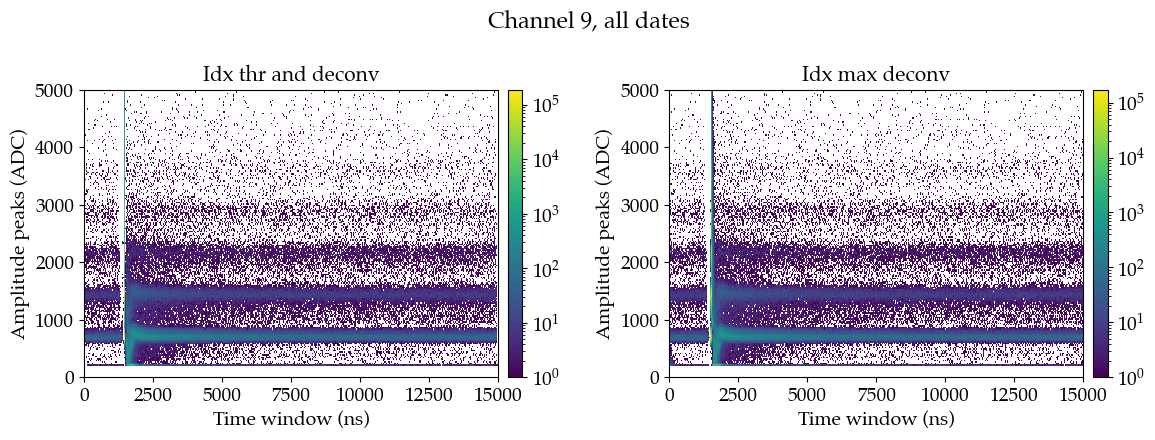

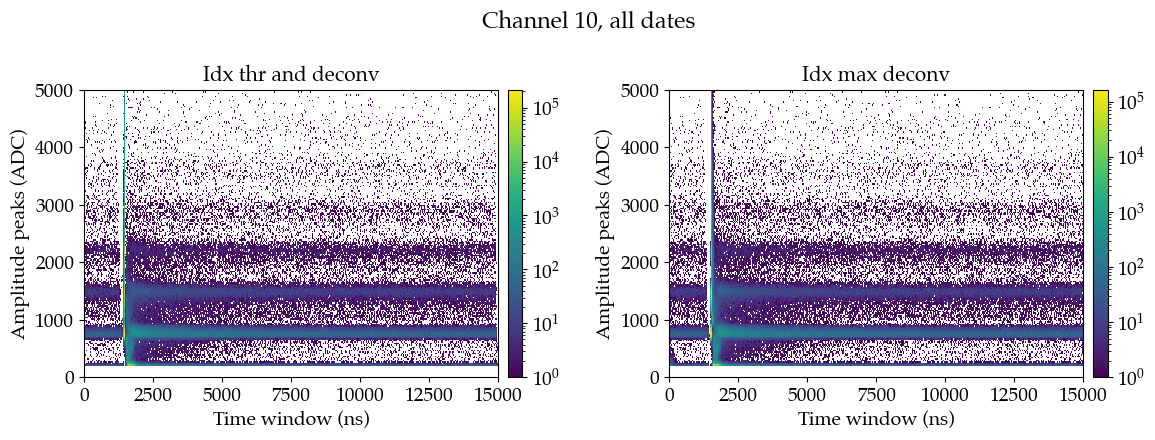

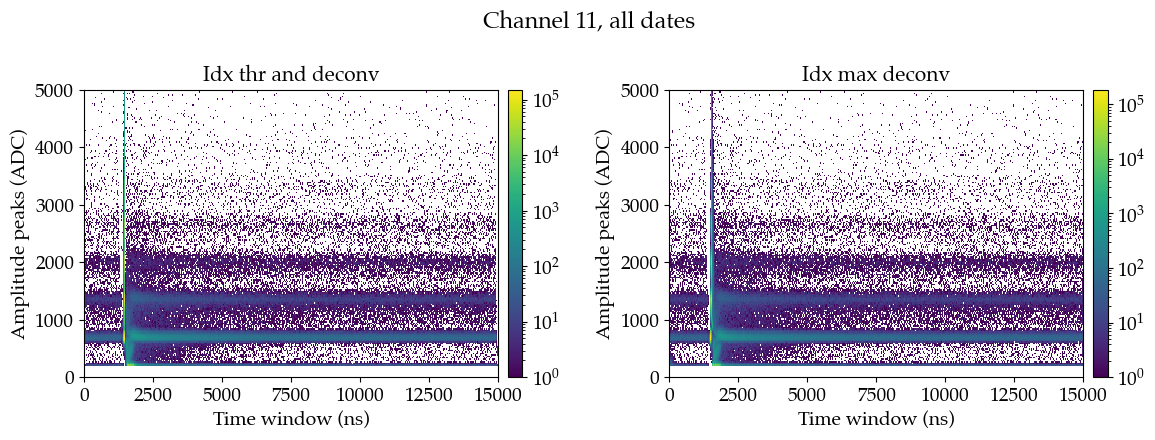

In [11]:
for ch in trigger_chs:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
    
    idx_vals1 = 2* np.concatenate([idx_thr_trigg    [date][ch] for date in idx_thr_trigg    .keys()])
    idx_vals2 = 2* np.concatenate([idx_max_trigg    [date][ch] for date in idx_max_trigg    .keys()])
    hei_vals1 =    np.concatenate([height_sg_d_trigg[date][ch] for date in height_sg_d_trigg.keys()])
    #hei_vals2 =    np.concatenate([height_sg_trigg  [date][ch] for date in height_sg_trigg  .keys()])

    fig0 = axs[0].hist2d(idx_vals1, hei_vals1, bins=(500, 200), range=((0, 15000), (0, 5000)), cmin=1, norm=LogNorm())
    fig1 = axs[1].hist2d(idx_vals2, hei_vals1, bins=(500, 200), range=((0, 15000), (0, 5000)), cmin=1, norm=LogNorm())

    for j, (ax, title, fig00) in enumerate(zip(axs.flatten(), ['Idx thr and deconv', 'Idx max deconv'], [fig0, fig1])):
        ax.set_xlabel('Time window (ns)', fontsize=14)
        ax.set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        ax.set_title(f"{title}", fontsize=15)
        fig.colorbar(fig00[3], ax=ax, pad=0.02)

    plt.suptitle(f'Channel {ch}, all dates')
    plt.tight_layout()
    plt.show()


In [12]:
def get_t_dist_from_hit_map(timestamps, amplitudes, bin_size=None):
    #bin_size is in time samples. bins_size=20 would be 40 ns
    unique_tmstmp = np.unique(timestamps)
    sum_ampl      = np.array([np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_tmstmp])
    if bin_size:
        reshaped = sum_ampl[:len(sum_ampl) - len(sum_ampl) % bin_size].reshape(-1, bin_size)
        sum_ampl   = reshaped.sum(axis=1)
        return bin_size*np.arange(len(sum_ampl)), sum_ampl
    else:
        return unique_tmstmp, sum_ampl

In [13]:
uniq_ts_thr_ch9, sum_ampls_thr_ch9 = get_t_dist_from_hit_map(2*np.concatenate([idx_thr_trigg    [date][9] for date in idx_thr_trigg    .keys()]),
                                                               np.concatenate([height_sg_d_trigg[date][9] for date in height_sg_d_trigg.keys()]))
uniq_ts_max_ch9, sum_ampls_max_ch9 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_trigg    [date][9] for date in idx_max_trigg    .keys()]),
                                                               np.concatenate([height_sg_d_trigg[date][9] for date in height_sg_d_trigg.keys()]))

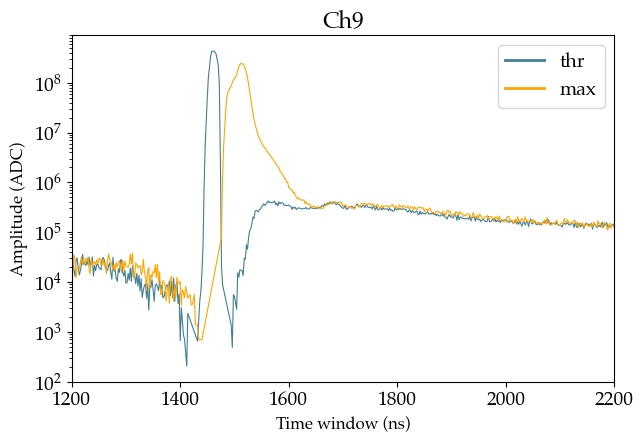

In [14]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_thr_ch9, sum_ampls_thr_ch9,  lw=0.8, c=fav_col,  label=f'thr')
plt.plot(uniq_ts_max_ch9, sum_ampls_max_ch9,  lw=0.8, c='orange', label=f'max')
plt.title('Ch9')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

In [15]:
uniq_ts_thr_ch10, sum_ampls_thr_ch10 = get_t_dist_from_hit_map(2*np.concatenate([idx_thr_trigg    [date][10] for date in idx_thr_trigg    .keys()]),
                                                                 np.concatenate([height_sg_d_trigg[date][10] for date in height_sg_d_trigg.keys()]))
uniq_ts_max_ch10, sum_ampls_max_ch10 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_trigg    [date][10] for date in idx_max_trigg    .keys()]),
                                                                 np.concatenate([height_sg_d_trigg[date][10] for date in height_sg_d_trigg.keys()]))

In [16]:
uniq_ts_thr_ch11, sum_ampls_thr_ch11 = get_t_dist_from_hit_map(2*np.concatenate([idx_thr_trigg    [date][11] for date in idx_thr_trigg    .keys()]),
                                                                 np.concatenate([height_sg_d_trigg[date][11] for date in height_sg_d_trigg.keys()]))
uniq_ts_max_ch11, sum_ampls_max_ch11 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_trigg    [date][11] for date in idx_max_trigg    .keys()]),
                                                                 np.concatenate([height_sg_d_trigg[date][11] for date in height_sg_d_trigg.keys()]))

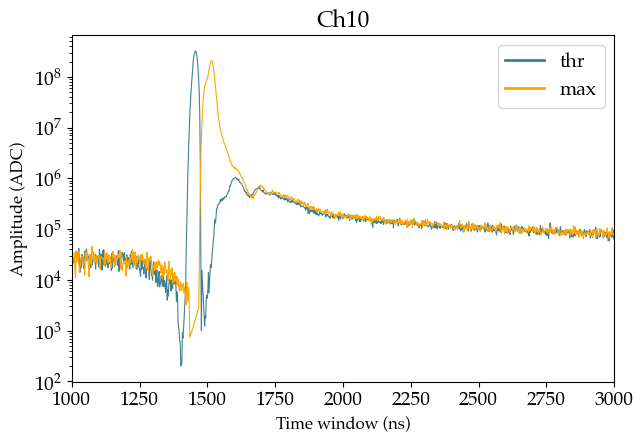

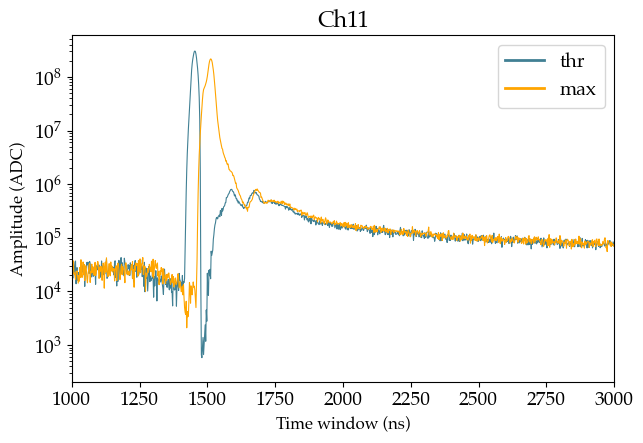

In [17]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_thr_ch10, sum_ampls_thr_ch10,  lw=0.8, c=fav_col,  label=f'thr')
plt.plot(uniq_ts_max_ch10, sum_ampls_max_ch10,  lw=0.8, c='orange', label=f'max')
plt.title('Ch10')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1000, 3000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_thr_ch11, sum_ampls_thr_ch11,  lw=0.8, c=fav_col,  label=f'thr')
plt.plot(uniq_ts_max_ch11, sum_ampls_max_ch11,  lw=0.8, c='orange', label=f'max')
plt.title('Ch11')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1000, 3000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Remove events before trigger

In [18]:
start_time = time.time()
idx_thr_trigg_pt     = {}
idx_max_trigg_pt     = {}
height_sg_d_trigg_pt = {}
num_evts_trigg_pt    = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files[:100]):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in trigger_chs:
        idx_after_cut1   = []
        idx_after_cut2   = []
        height_after_cut = []
        num_evts         = 0
        idx_thr_ch = d['idx_peaks_thr_trigg']         .item()[ch]
        idx_max_ch = d['idx_peaks_max_trigg']         .item()[ch]
        heights_ch = d['height_peaks_sg_deconv_trigg'].item()[ch]
        
        for idxs1, idxs2, vals in zip(idx_thr_ch, idx_max_ch, heights_ch):
            if len(idxs2)==0:
                continue
            noise_evts = (np.array(idxs2)<650)&(np.array(vals)>100)
            if np.any(noise_evts):
                continue
            #if np.any(np.array(vals) > 1000):
            #    continue
            else:
                idx_after_cut1  .append(idxs1)
                idx_after_cut2  .append(idxs2)
                height_after_cut.append(vals)
                num_evts += 1
                
        if date not in idx_thr_trigg_pt:
            print(date)
            idx_thr_trigg_pt    [date] = {}
            idx_max_trigg_pt    [date] = {}
            height_sg_d_trigg_pt[date] = {}
            num_evts_trigg_pt   [date] = {}

        if ch not in idx_thr_trigg_pt[date]:
            try:
                idx_thr_trigg_pt    [date][ch] = np.concatenate(idx_after_cut1)
                idx_max_trigg_pt    [date][ch] = np.concatenate(idx_after_cut2)
                height_sg_d_trigg_pt[date][ch] = np.concatenate(height_after_cut)
                num_evts_trigg_pt   [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_thr_trigg_pt    [date][ch] = np.concatenate((idx_thr_trigg_pt    [date][ch], np.concatenate(idx_after_cut1)))
                idx_max_trigg_pt    [date][ch] = np.concatenate((idx_max_trigg_pt    [date][ch], np.concatenate(idx_after_cut2)))
                height_sg_d_trigg_pt[date][ch] = np.concatenate((height_sg_d_trigg_pt[date][ch], np.concatenate(height_after_cut)))
                num_evts_trigg_pt   [date][ch] = np.concatenate((num_evts_trigg_pt   [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1380
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 76.01840996742249 s, 1.2669734994570414 min


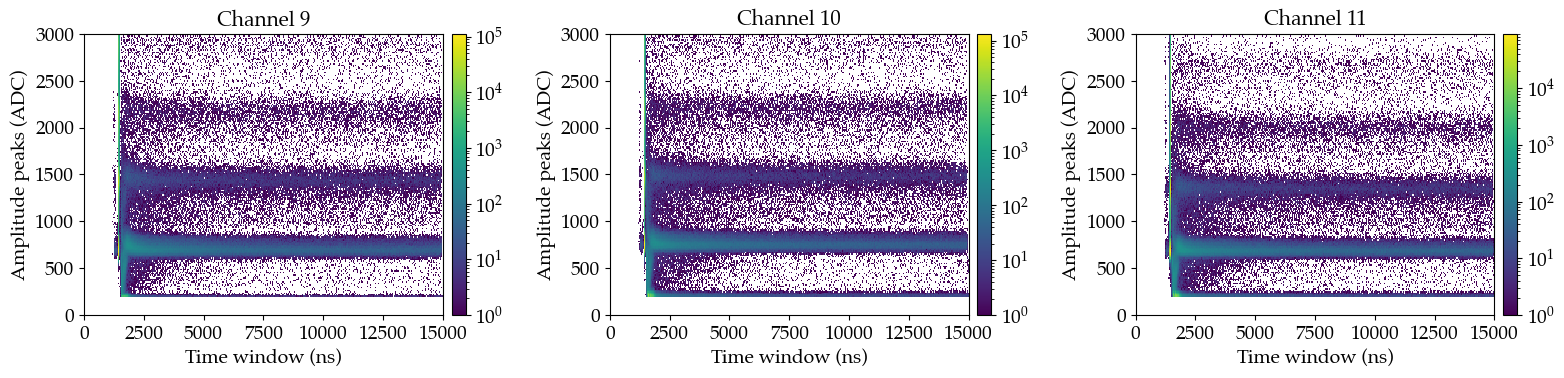

In [19]:
sel_dates = idx_thr_trigg_pt.keys()
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i,ch in enumerate(trigger_chs):
    try:
        ch_idxs = np.concatenate([idx_thr_trigg_pt    [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_d_trigg_pt[date][ch] for date in sel_dates])
    
        fig0 = axs[i].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 3000)), cmin=1, norm=LogNorm())
        axs[i].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

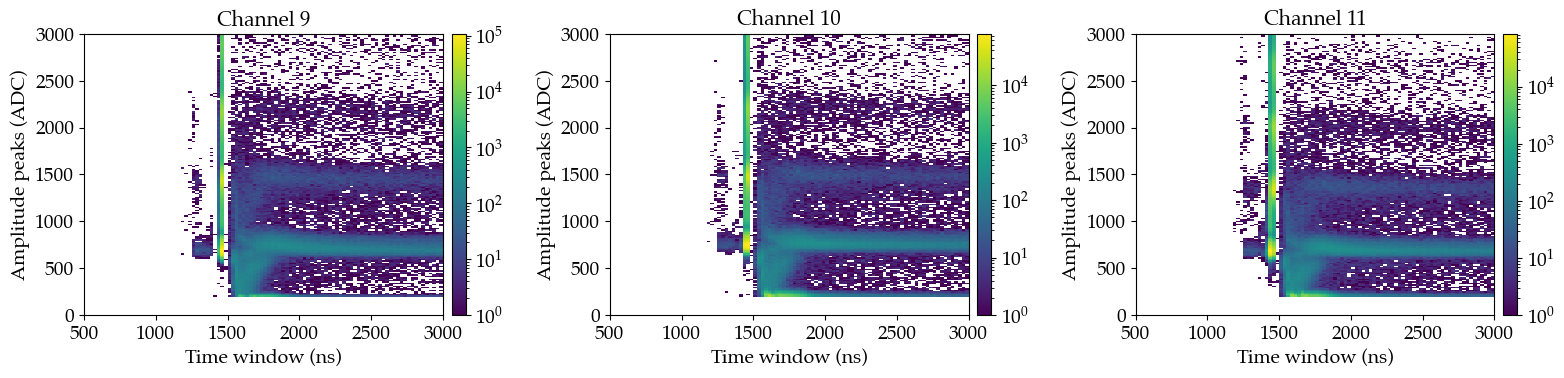

In [20]:
sel_dates = idx_thr_trigg_pt.keys()
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i,ch in enumerate(trigger_chs):
    try:
        ch_idxs = np.concatenate([idx_thr_trigg_pt    [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_d_trigg_pt[date][ch] for date in sel_dates])
    
        fig0 = axs[i].hist2d(ch_idxs*2, ch_vals, bins=(100, 200), range=((500, 3000), (0, 3000)), cmin=1, norm=LogNorm())
        axs[i].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

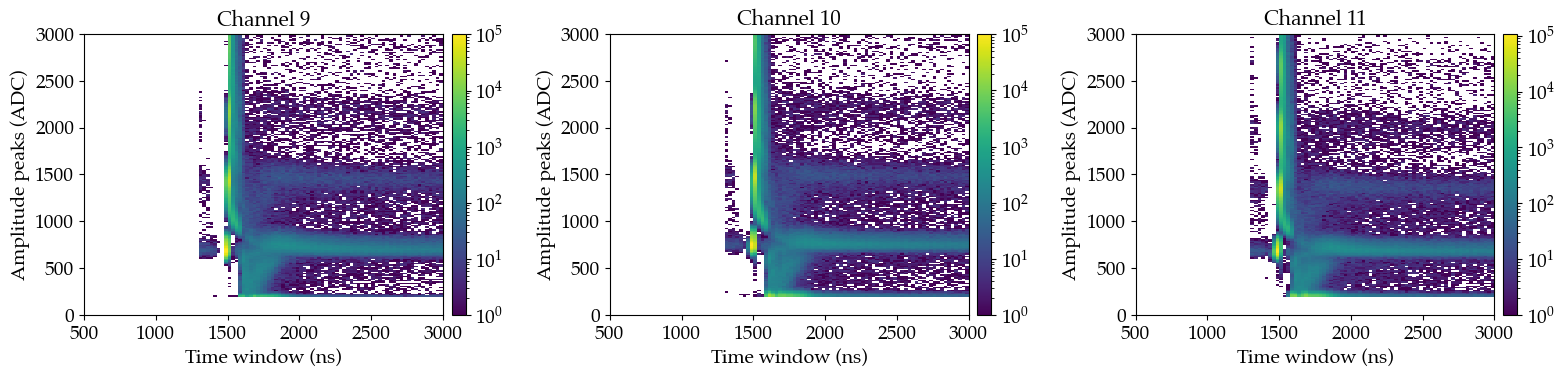

In [21]:
sel_dates = idx_max_trigg_pt.keys()
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i,ch in enumerate(trigger_chs):
    try:
        ch_idxs = np.concatenate([idx_max_trigg_pt    [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_d_trigg_pt[date][ch] for date in sel_dates])
    
        fig0 = axs[i].hist2d(ch_idxs*2, ch_vals, bins=(100, 200), range=((500, 3000), (0, 3000)), cmin=1, norm=LogNorm())
        axs[i].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

In [22]:
uniq_ts_thr_pt_ch9, sum_ampls_thr_pt_ch9 = get_t_dist_from_hit_map(2*np.concatenate([idx_thr_trigg_pt    [date][9] for date in idx_thr_trigg_pt    .keys()]),
                                                                     np.concatenate([height_sg_d_trigg_pt[date][9] for date in height_sg_d_trigg_pt.keys()]))
uniq_ts_max_pt_ch9, sum_ampls_max_pt_ch9 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_trigg_pt    [date][9] for date in idx_max_trigg_pt    .keys()]),
                                                                     np.concatenate([height_sg_d_trigg_pt[date][9] for date in height_sg_d_trigg_pt.keys()]))

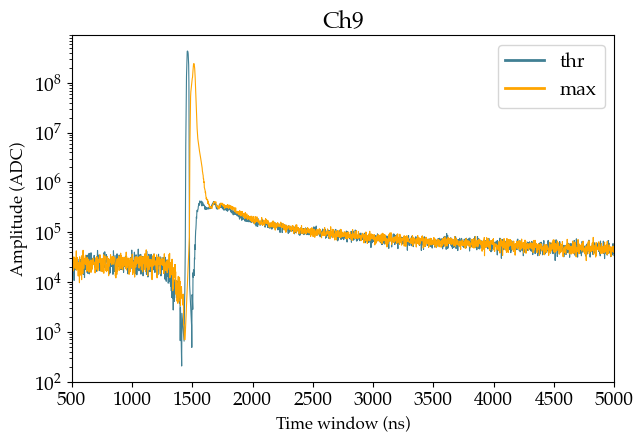

In [40]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_thr_ch9, sum_ampls_thr_ch9,  lw=0.8, c=fav_col,     label=f'thr')
plt.plot(uniq_ts_max_ch9, sum_ampls_max_ch9,  lw=0.8, c='orange',    label=f'max')
#plt.plot(uniq_ts_thr_pt_ch9, sum_ampls_thr_pt_ch9,  lw=0.8, c='indianred', label=f'pretrigg thr')
#plt.plot(uniq_ts_max_pt_ch9, sum_ampls_max_pt_ch9,  lw=0.8, c='k',         label=f'pretrigg max')
plt.title('Ch9')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(500, 5000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

In [24]:
def get_ch_info(min_dist, cal=None, month=None, nfiles=10000, ch=8):
    if min_dist==50:
        if month:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_run-{month}*')
        else:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_run-*')
    else:
        if month:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_ch{ch}_run-{month}*')
        else:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_ch{ch}_run-*')
    sorted_files = sorted(filt_files, key=extract_date_obj_and_number)
    
    start_time = time.time()
    
    idx_max   = {}
    idx_thr   = {}
    height_sg = {}
    if ch<9:
        filt_evts = {}
        
        print(len(sorted_files))
        for ifile,filename in enumerate(sorted_files[:nfiles]):
            if ifile%20==0:
                print(ifile)
            d          = np.load(filename, allow_pickle=True)
            date, fnum = extract_date_and_number(filename)
        
            if date not in idx_max:
                print(date)
                filt_evts[date] = d['filt_evts_dict'].item()[ch]
                idx_max  [date] = d['idx_peaks_max'] .item()[ch]
                idx_thr  [date] = d['idx_peaks_thr'] .item()[ch]
                if cal:
                    height_sg[date] = (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0]
                else:
                    height_sg[date] = d['height_peaks_sg'].item()[ch]
            else:
                for ch in [8]:
                    try:
                        filt_evts[date] = np.concatenate((filt_evts[date], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
                        idx_max  [date] = np.concatenate((idx_max  [date], d['idx_peaks_max'].item()[ch]))
                        idx_thr  [date] = np.concatenate((idx_thr  [date], d['idx_peaks_thr'].item()[ch]))
                        if cal:
                            height_sg[date] = np.concatenate((height_sg[date], (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0]))
                        else:
                            height_sg[date] = np.concatenate((height_sg[date], d['height_peaks_sg'].item()[ch]))
                    except Exception as e:
                        print(date, fnum, filename, ch, str(e))
                        continue
        return filt_evts, idx_max, idx_thr, height_sg
                        
    else:
        print(len(sorted_files))
        for ifile,filename in enumerate(sorted_files[:nfiles]):
            if ifile%20==0:
                print(ifile)
            d          = np.load(filename, allow_pickle=True)
            date, fnum = extract_date_and_number(filename)
        
            if date not in idx_max:
                print(date)
                idx_max[date] = d['idx_peaks_max_trigg'].item()[ch]
                idx_thr[date] = d['idx_peaks_thr_trigg'].item()[ch]
                if cal:
                    height_sg[date] = (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0]
                else:
                    height_sg[date] = d['height_peaks_sg_trigg'].item()[ch]
            else:
                for ch in [ch]:
                    try:
                        idx_max[date] = np.concatenate((idx_max[date], d['idx_peaks_max_trigg']  .item()[ch]))
                        idx_thr[date] = np.concatenate((idx_thr[date], d['idx_peaks_thr_trigg']  .item()[ch]))
                        if cal:
                            height_sg[date] = np.concatenate((height_sg[date], (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0]))
                        else:
                            height_sg[date] = np.concatenate((height_sg[date], d['height_peaks_sg_trigg'].item()[ch]))
                    except Exception as e:
                        print(date, fnum, filename, ch, str(e))
                        continue
                    
    end_time     = time.time()                
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")
    return idx_max, idx_thr, height_sg


In [25]:
idx_max_ch9_20,  idx_thr_ch9_20,  height_sg_ch9_20  = get_ch_info(10, ch=9, nfiles=100)
idx_max_ch9_50,  idx_thr_ch9_50,  height_sg_ch9_50  = get_ch_info(25, ch=9, nfiles=100)
idx_max_ch9_100, idx_thr_ch9_100, height_sg_ch9_100 = get_ch_info(50, ch=9, nfiles=100)

1367
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 6.27070689201355 s, 0.10451178153355917 min
1383
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 6.2634499073028564 s, 0.10439083178838095 min
1379
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 17.643882989883423 s, 0.29406471649805704 min


In [26]:
uniq_ts_ch9_20_max, sum_ampls_ch9_20_max   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_20   [date]) for date in idx_max_ch9_20   .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_20 [date]) for date in height_sg_ch9_20 .keys()]))
uniq_ts_ch9_20_thr, sum_ampls_ch9_20_thr   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_20   [date]) for date in idx_thr_ch9_20   .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_20 [date]) for date in height_sg_ch9_20 .keys()]))
uniq_ts_ch9_50_max, sum_ampls_ch9_50_max   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_50   [date]) for date in idx_max_ch9_50   .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_50 [date]) for date in height_sg_ch9_50 .keys()]))
uniq_ts_ch9_50_thr, sum_ampls_ch9_50_thr   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_50   [date]) for date in idx_thr_ch9_50   .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_50 [date]) for date in height_sg_ch9_50 .keys()]))
uniq_ts_ch9_100_max, sum_ampls_ch9_100_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_100  [date]) for date in idx_max_ch9_100  .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_100[date]) for date in height_sg_ch9_100.keys()]))
uniq_ts_ch9_100_thr, sum_ampls_ch9_100_thr = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_100  [date]) for date in idx_thr_ch9_100  .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_100[date]) for date in height_sg_ch9_100.keys()]))

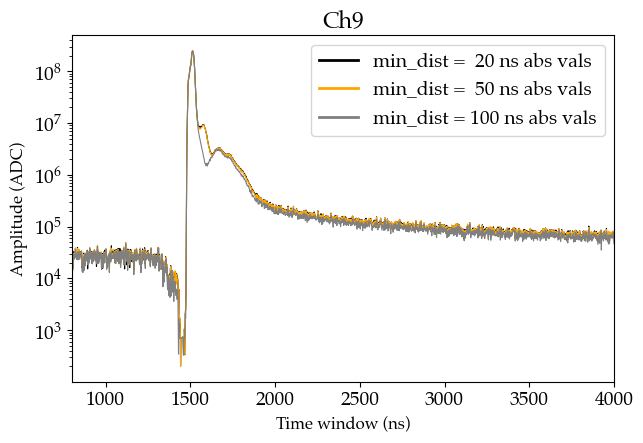

In [39]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_ch9_20_max,  sum_ampls_ch9_20_max,  lw=0.8, c='k',      label=f'min_dist =  20 ns abs vals')
plt.plot(uniq_ts_ch9_50_max,  sum_ampls_ch9_50_max,  lw=0.8, c='orange', label=f'min_dist =  50 ns abs vals')
plt.plot(uniq_ts_ch9_100_max, sum_ampls_ch9_100_max, lw=0.8, c='grey',   label=f'min_dist = 100 ns abs vals')
plt.title('Ch9')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 4000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

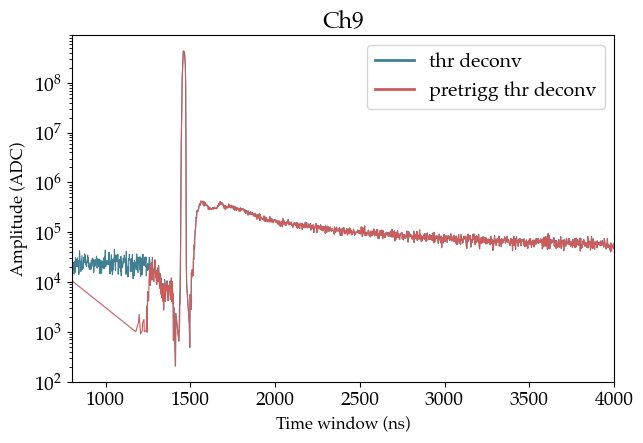

In [27]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_thr_ch9, sum_ampls_thr_ch9,  lw=0.8, c=fav_col,     label=f'thr deconv')
#plt.plot(uniq_ts_max_ch9, sum_ampls_max_ch9,  lw=0.8, c='orange',    label=f'max deconv')
plt.plot(uniq_ts_thr_pt_ch9, sum_ampls_thr_pt_ch9,  lw=0.8, c='indianred', label=f'pretrigg thr deconv')
#plt.plot(uniq_ts_max_pt_ch9, sum_ampls_max_pt_ch9,  lw=0.8, c='k',         label=f'pretrigg max deconv')
#plt.plot(uniq_ts_ch9_20_max,  sum_ampls_ch9_20_max,  lw=0.8, c='k',      label=f'min_dist =  20 ns')
#plt.plot(uniq_ts_ch9_50_max,  sum_ampls_ch9_50_max,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
#plt.plot(uniq_ts_ch9_100_max, sum_ampls_ch9_100_max, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch9')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 4000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

### Reject high light events

In [28]:
start_time = time.time()
idx_thr_trigg_hl     = {}
idx_max_trigg_hl     = {}
height_sg_d_trigg_hl = {}
num_evts_trigg_hl    = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files[:100]):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in trigger_chs:
        idx_after_cut1   = []
        idx_after_cut2   = []
        height_after_cut = []
        num_evts         = 0
        idx_thr_ch = d['idx_peaks_thr_trigg']         .item()[ch]
        idx_max_ch = d['idx_peaks_max_trigg']         .item()[ch]
        heights_ch = d['height_peaks_sg_deconv_trigg'].item()[ch]
        
        for idxs1, idxs2, vals in zip(idx_thr_ch, idx_max_ch, heights_ch):
            if len(idxs2)==0:
                continue
            #noise_evts = (np.array(idxs2)<650)&(np.array(vals)>100)
            #if np.any(noise_evts):
            #    continue
            if np.any(np.array(vals) > 4000):
                continue
            else:
                idx_after_cut1  .append(idxs1)
                idx_after_cut2  .append(idxs2)
                height_after_cut.append(vals)
                num_evts += 1
                
        if date not in idx_thr_trigg_hl:
            print(date)
            idx_thr_trigg_hl    [date] = {}
            idx_max_trigg_hl    [date] = {}
            height_sg_d_trigg_hl[date] = {}
            num_evts_trigg_hl   [date] = {}

        if ch not in idx_thr_trigg_hl[date]:
            try:
                idx_thr_trigg_hl    [date][ch] = np.concatenate(idx_after_cut1)
                idx_max_trigg_hl    [date][ch] = np.concatenate(idx_after_cut2)
                height_sg_d_trigg_hl[date][ch] = np.concatenate(height_after_cut)
                num_evts_trigg_hl   [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_thr_trigg_hl    [date][ch] = np.concatenate((idx_thr_trigg_hl    [date][ch], np.concatenate(idx_after_cut1)))
                idx_max_trigg_hl    [date][ch] = np.concatenate((idx_max_trigg_hl    [date][ch], np.concatenate(idx_after_cut2)))
                height_sg_d_trigg_hl[date][ch] = np.concatenate((height_sg_d_trigg_hl[date][ch], np.concatenate(height_after_cut)))
                num_evts_trigg_hl   [date][ch] = np.concatenate((num_evts_trigg_hl   [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1380
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 70.0053129196167 s, 1.166755215326945 min


In [29]:
uniq_ts_thr_hl_ch9, sum_ampls_thr_hl_ch9 = get_t_dist_from_hit_map(2*np.concatenate([idx_thr_trigg_hl    [date][9] for date in idx_thr_trigg_hl    .keys()]),
                                                                     np.concatenate([height_sg_d_trigg_hl[date][9] for date in height_sg_d_trigg_hl.keys()]))
uniq_ts_max_hl_ch9, sum_ampls_max_hl_ch9 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_trigg_hl    [date][9] for date in idx_max_trigg_hl    .keys()]),
                                                                     np.concatenate([height_sg_d_trigg_hl[date][9] for date in height_sg_d_trigg_hl.keys()]))

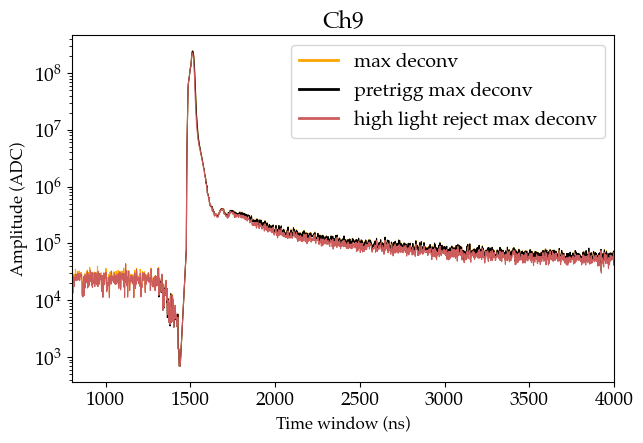

In [30]:
fig = plt.figure(figsize=(7, 4.5))
#plt.plot(uniq_ts_thr_ch9, sum_ampls_thr_ch9,  lw=0.8, c=fav_col,     label=f'thr deconv')
plt.plot(uniq_ts_max_ch9, sum_ampls_max_ch9,  lw=0.8, c='orange',    label=f'max deconv')
#plt.plot(uniq_ts_thr_pt_ch9, sum_ampls_thr_pt_ch9,  lw=0.8, c='indianred', label=f'pretrigg thr deconv')
plt.plot(uniq_ts_max_pt_ch9, sum_ampls_max_pt_ch9,  lw=0.8, c='k',         label=f'pretrigg max deconv')
#plt.plot(uniq_ts_thr_hl_ch9, sum_ampls_thr_hl_ch9,  lw=0.8, c='indianred', label=f'pretrigg thr deconv')
plt.plot(uniq_ts_max_hl_ch9, sum_ampls_max_hl_ch9,  lw=0.8, c='indianred',         label=f'high light reject max deconv')
#plt.plot(uniq_ts_ch9_20_max,  sum_ampls_ch9_20_max,  lw=0.8, c='k',      label=f'min_dist =  20 ns')
#plt.plot(uniq_ts_ch9_50_max,  sum_ampls_ch9_50_max,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
#plt.plot(uniq_ts_ch9_100_max, sum_ampls_ch9_100_max, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch9')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 4000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

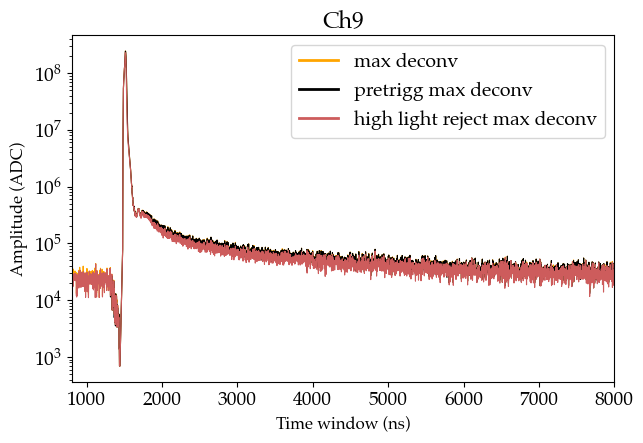

In [36]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_max_ch9,    sum_ampls_max_ch9,     lw=0.8, c='orange',    label=f'max deconv')
plt.plot(uniq_ts_max_pt_ch9, sum_ampls_max_pt_ch9,  lw=0.8, c='k',         label=f'pretrigg max deconv')
plt.plot(uniq_ts_max_hl_ch9, sum_ampls_max_hl_ch9,  lw=0.8, c='indianred', label=f'high light reject max deconv')
plt.title('Ch9')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 8000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Try to select single PE per whole event as in LLAMA

In [31]:
start_time = time.time()

idx_max_trigg_1pe     = {}
height_sg_d_trigg_1pe = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files[:100]):
    if ifile%20==0:
        print(ifile)

    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in trigger_chs:
        
        npeak_wf = np.array([len(el) for el in d['idx_peaks_max_trigg'].item()[ch]])
        sel1     = npeak_wf==1
        indices1 = np.concatenate(d['idx_peaks_max_trigg']         .item()[ch][sel1]).astype(int)
        heights1 = np.concatenate(d['height_peaks_sg_deconv_trigg'].item()[ch][sel1])
        
        sel3     = heights1 < 1200 #amplitude < 1200 ADC to select only single PE
        indices1 = indices1[sel3]
        heights1 = heights1[sel3]
        
    
        if date not in idx_max_trigg_1pe:
            idx_max_trigg_1pe    [date] = {}
            height_sg_d_trigg_1pe[date] = {}
            
        if ch not in idx_max_trigg_1pe[date]:
            try:
                idx_max_trigg_1pe    [date][ch] = indices1
                height_sg_d_trigg_1pe[date][ch] = heights1
            except Exception as e:
                print(e)
                continue
                
        else:
            try:
                idx_max_trigg_1pe    [date][ch] = np.concatenate((idx_max_trigg_1pe    [date][ch], indices1))
                height_sg_d_trigg_1pe[date][ch] = np.concatenate((height_sg_d_trigg_1pe[date][ch], heights1))
            except Exception as e:
                print(e)
                continue
                
end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1380
0
20
40
60
80
Elapsed time: 51.57264518737793 s, 0.8595440864562989 min


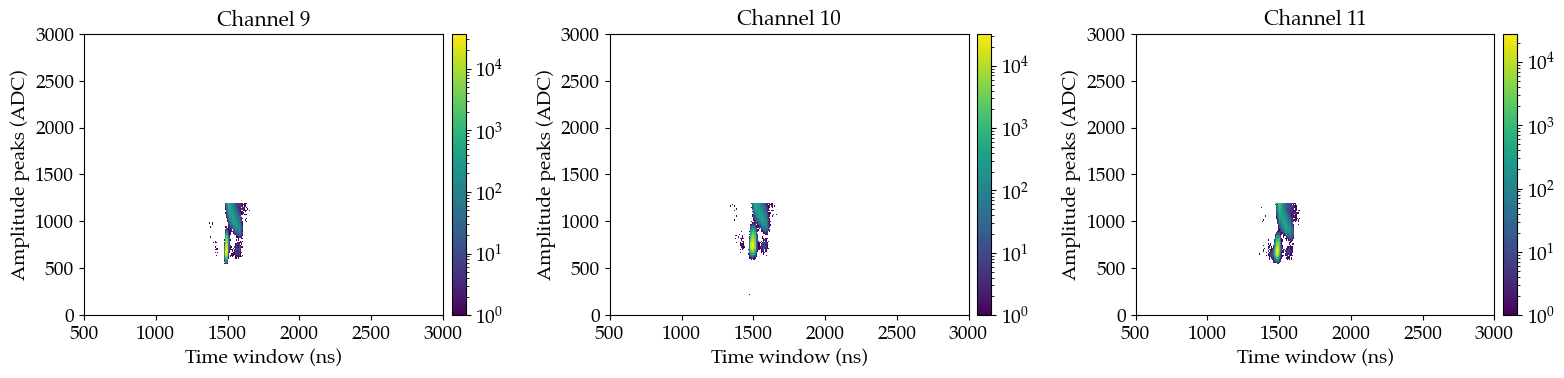

In [32]:
sel_dates = idx_thr_trigg_pt.keys()
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i,ch in enumerate(trigger_chs):
    try:
        ch_idxs = np.concatenate([idx_max_trigg_1pe    [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_d_trigg_1pe[date][ch] for date in sel_dates])
    
        fig0 = axs[i].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((500, 3000), (0, 3000)), cmin=1, norm=LogNorm())
        axs[i].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

In [33]:
uniq_ts_max_1pe_ch9, sum_ampls_max_1pe_ch9 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_trigg_1pe    [date][9] for date in idx_max_trigg_1pe    .keys()]),
                                                                       np.concatenate([height_sg_d_trigg_1pe[date][9] for date in height_sg_d_trigg_1pe.keys()]))

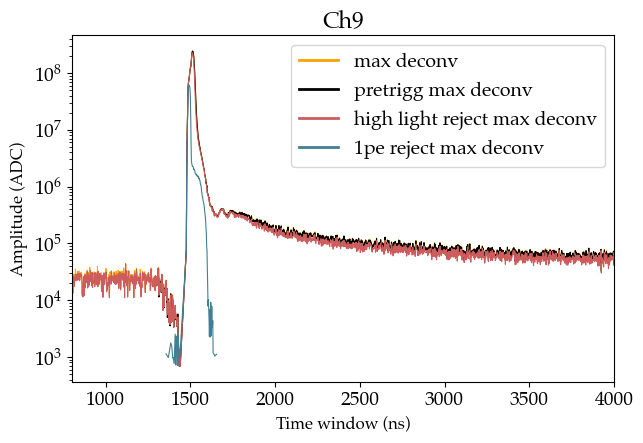

In [37]:
fig = plt.figure(figsize=(7, 4.5))
#plt.plot(uniq_ts_thr_ch9, sum_ampls_thr_ch9,  lw=0.8, c=fav_col,     label=f'thr deconv')
plt.plot(uniq_ts_max_ch9, sum_ampls_max_ch9,  lw=0.8, c='orange',    label=f'max deconv')
#plt.plot(uniq_ts_thr_pt_ch9, sum_ampls_thr_pt_ch9,  lw=0.8, c='indianred', label=f'pretrigg thr deconv')
plt.plot(uniq_ts_max_pt_ch9, sum_ampls_max_pt_ch9,  lw=0.8, c='k',         label=f'pretrigg max deconv')
#plt.plot(uniq_ts_thr_hl_ch9, sum_ampls_thr_hl_ch9,  lw=0.8, c='indianred', label=f'pretrigg thr deconv')
plt.plot(uniq_ts_max_hl_ch9, sum_ampls_max_hl_ch9,  lw=0.8, c='indianred',         label=f'high light reject max deconv')
plt.plot(uniq_ts_max_1pe_ch9, sum_ampls_max_1pe_ch9,  lw=0.8, c=fav_col,         label=f'1pe reject max deconv')
#plt.plot(uniq_ts_ch9_20_max,  sum_ampls_ch9_20_max,  lw=0.8, c='k',      label=f'min_dist =  20 ns')
#plt.plot(uniq_ts_ch9_50_max,  sum_ampls_ch9_50_max,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
#plt.plot(uniq_ts_ch9_100_max, sum_ampls_ch9_100_max, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch9')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 4000)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Abs values: